<a href="https://colab.research.google.com/github/anandt555/BigData-Practice/blob/main/edl_updated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Evidential deep learning**

### **Evidential deep learning With MNIST**





In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image

# Download MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=1000, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=1000, shuffle=False)

# LeNet model with Dirichlet distribution for Evidential Deep Learning
class LeNetDirichlet(nn.Module):
    def __init__(self):
        super(LeNetDirichlet, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 4*4*50)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        alpha = torch.abs(x) + 1  # Use absolute values for simplicity, adjust as needed

        u = 10 / torch.sum(alpha, dim=1, keepdim=True)

        prob = alpha / torch.sum(alpha, 1, keepdim=True)

        return prob, u, alpha

# Train LeNet model with Dirichlet distribution for Evidential Deep Learning
lenet_dirichlet = LeNetDirichlet()
criterion_dirichlet = nn.CrossEntropyLoss()
optimizer_dirichlet = optim.Adam(lenet_dirichlet.parameters(), lr=0.001)

for epoch in range(10):
    lenet_dirichlet.train()
    for inputs, labels in train_loader:
        optimizer_dirichlet.zero_grad()
        outputs, _, _ = lenet_dirichlet(inputs)
        loss = criterion_dirichlet(outputs, labels)
        loss.backward()
        optimizer_dirichlet.step()

    lenet_dirichlet.eval()
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs, _, _ = lenet_dirichlet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs, _, _ = lenet_dirichlet(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    print('epoch %d - training accuracy: %2.4f \t testing accuracy: %2.4f' %
          (epoch+1, correct_train / total_train, correct_test / total_test))

100%|██████████| 9912422/9912422 [00:00<00:00, 145697183.68it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 24853445.59it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 112291016.20it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 10264293.52it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



epoch 1 - training accuracy: 0.7368 	 testing accuracy: 0.7424
epoch 2 - training accuracy: 0.9094 	 testing accuracy: 0.9168
epoch 3 - training accuracy: 0.9518 	 testing accuracy: 0.9555
epoch 4 - training accuracy: 0.9606 	 testing accuracy: 0.9627
epoch 5 - training accuracy: 0.9655 	 testing accuracy: 0.9673
epoch 6 - training accuracy: 0.9694 	 testing accuracy: 0.9710
epoch 7 - training accuracy: 0.9725 	 testing accuracy: 0.9744
epoch 8 - training accuracy: 0.9746 	 testing accuracy: 0.9762
epoch 9 - training accuracy: 0.9767 	 testing accuracy: 0.9784
epoch 10 - training accuracy: 0.9789 	 testing accuracy: 0.9790


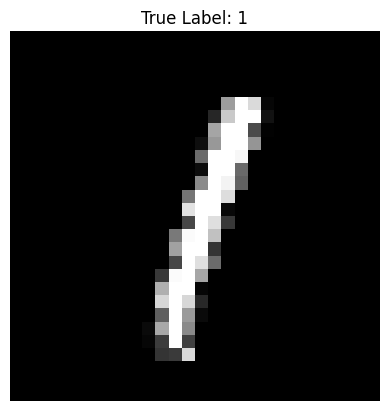

Predicted Probabilities: tensor([[0.0856, 0.2289, 0.0857, 0.0857, 0.0857, 0.0857, 0.0857, 0.0856, 0.0857,
         0.0857]])
Uncertainty: tensor([[0.0122]])
Alpha Parameters: tensor([[  1.0882, 805.4111,   1.2244,   1.4984,   1.7173,   1.2568,   1.7364,
           1.1229,   1.5463,   1.4140]])


In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Assuming you have the original MNIST dataset loaded
transform_display = transforms.Compose([transforms.ToPILImage(), transforms.Resize((28, 28))])

# Display the original image
test_image, test_label = test_dataset[5]  # Access the 5th test image
plt.imshow(transform_display(test_image), cmap='gray')
plt.title(f'True Label: {test_label}')
plt.axis('off')
plt.show()

lenet_dirichlet.eval()

input_image = test_image.unsqueeze(0)

with torch.no_grad():
    outputs, uncertainty, alpha = lenet_dirichlet(input_image)

probabilities = torch.nn.functional.softmax(outputs, dim=1)
print("Predicted Probabilities:", probabilities)
print("Uncertainty:", uncertainty)
print("Alpha Parameters:", alpha)
#print("True Label:", test_label.item())


### **Evidential deep learning with CIFAR10**

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from PIL import Image

# Download CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data1', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# LeNet model with Dirichlet distribution for Evidential Deep Learning
class LeNetDirichletCIFAR(nn.Module):
    def __init__(self):
        super(LeNetDirichletCIFAR, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)  # Adjust input channels
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(8*8*64, 512)  # Adjust the input size for fully connected layer
        self.fc2 = nn.Linear(512, 10)  # Adjust output classes

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 8*8*64)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        alpha = torch.abs(x) + 1  # Use absolute values for simplicity, adjust as needed

        u = 10 / torch.sum(alpha, dim=1, keepdim=True)

        prob = alpha / torch.sum(alpha, 1, keepdim=True)

        return prob, u, alpha

# Train LeNet model with Dirichlet distribution for Evidential Deep Learning
lenet_dirichlet_CIFAR = LeNetDirichletCIFAR()
criterion_dirichlet = nn.CrossEntropyLoss()
optimizer_dirichlet = optim.Adam(lenet_dirichlet_CIFAR.parameters(), lr=0.001)

for epoch in range(20):
    lenet_dirichlet_CIFAR.train()
    for inputs, labels in train_loader:
        optimizer_dirichlet.zero_grad()
        outputs, _, _ = lenet_dirichlet_CIFAR(inputs)
        loss = criterion_dirichlet(outputs, labels)
        loss.backward()
        optimizer_dirichlet.step()

    lenet_dirichlet_CIFAR.eval()
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs, _, _ = lenet_dirichlet_CIFAR(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs, _, _ = lenet_dirichlet_CIFAR(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    print('epoch %d - training accuracy: %2.4f \t testing accuracy: %2.4f' %
          (epoch+1, correct_train / total_train, correct_test / total_test))

100%|██████████| 170498071/170498071 [00:02<00:00, 68956165.57it/s]


Extracting ./data1/cifar-10-python.tar.gz to ./data1
Files already downloaded and verified
epoch 1 - training accuracy: 0.5139 	 testing accuracy: 0.5109
epoch 2 - training accuracy: 0.5936 	 testing accuracy: 0.5756
epoch 3 - training accuracy: 0.6489 	 testing accuracy: 0.6136
epoch 4 - training accuracy: 0.6811 	 testing accuracy: 0.6280
epoch 5 - training accuracy: 0.7188 	 testing accuracy: 0.6522
epoch 6 - training accuracy: 0.7481 	 testing accuracy: 0.6740
epoch 7 - training accuracy: 0.7573 	 testing accuracy: 0.6670
epoch 8 - training accuracy: 0.7832 	 testing accuracy: 0.6803
epoch 9 - training accuracy: 0.7994 	 testing accuracy: 0.6790
epoch 10 - training accuracy: 0.8128 	 testing accuracy: 0.6822
epoch 11 - training accuracy: 0.8190 	 testing accuracy: 0.6809
epoch 12 - training accuracy: 0.8300 	 testing accuracy: 0.6826
epoch 13 - training accuracy: 0.8359 	 testing accuracy: 0.6754
epoch 14 - training accuracy: 0.8394 	 testing accuracy: 0.6812
epoch 15 - training ac

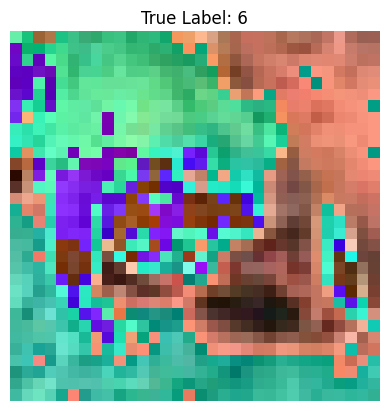

Predicted Probabilities: tensor([[0.0863, 0.0863, 0.0864, 0.0863, 0.0865, 0.0863, 0.2229, 0.0863, 0.0863,
         0.0863]])
Predicted Class: Frog
Uncertainty: 0.04694695770740509
Alpha Parameters: [1.0372369289398193, 1.036574363708496, 1.1590166091918945, 1.082773208618164, 1.4299254417419434, 1.030117154121399, 203.13356018066406, 1.0300381183624268, 1.0586154460906982, 1.0084997415542603]
True Label: Frog


In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Assuming you have the original CIFAR-10 dataset loaded
transform_display = transforms.Compose([transforms.ToPILImage(), transforms.Resize((32, 32))])

# Display the original image
test_image, true_label = test_dataset[5]  # Access the 5th test image
plt.imshow(transform_display(test_image), cmap='gray')
plt.title(f'True Label: {true_label}')
plt.axis('off')
plt.show()

# Continue with the rest of the code for inference
lenet_dirichlet_CIFAR.eval()
class_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']


# Reshape the input image to match the model's input size
input_image = test_image.unsqueeze(0)  # Add batch dimension

with torch.no_grad():
    outputs, uncertainty, alpha = lenet_dirichlet_CIFAR(input_image)

predicted_probabilities = torch.nn.functional.softmax(outputs, dim=1)
predicted_class = torch.argmax(predicted_probabilities, dim=1).item()

print("Predicted Probabilities:", predicted_probabilities)
print("Predicted Class:", class_labels[predicted_class])
print("Uncertainty:", uncertainty.item())
print("Alpha Parameters:", alpha.squeeze().tolist())  # Convert alpha tensor to list for easier printing
print("True Label:", class_labels[true_label])  # Convert true label tensor to Python scalar for display

## ***Evidential deep learning And Mixup***

###**Evidential deep learning And Mixup MNIST**

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

# Download MNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# LeNet model with Dirichlet distribution for Evidential Deep Learning and mixup
class LeNetDirichletMixup(nn.Module):
    def __init__(self):
        super(LeNetDirichletMixup, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, kernel_size=5, stride=1, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(20, 50, kernel_size=5, stride=1, padding=0)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 4*4*50)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        alpha = torch.abs(x) + 1  # Use absolute values for simplicity, adjust as needed

        u = 10 / torch.sum(alpha, dim=1, keepdim=True)

        prob = alpha / torch.sum(alpha, 1, keepdim=True)

        return prob, u, alpha

# # Mixup function for Evidential Deep Learning
# def mixup_data(x, y, alpha=0.1):
#     lam = np.random.beta(alpha, alpha)
#     batch_size = x.size()[0]
#     index = torch.randperm(batch_size).to(x.device)
#     mixed_x = lam * x + (1 - lam) * x[index, :]
#     mixed_y = lam * y + (1 - lam) * y[index, :]
#     return mixed_x, mixed_y
# epoch 1 - training accuracy: 0.6890 	 testing accuracy: 0.6892
# epoch 2 - training accuracy: 0.6864 	 testing accuracy: 0.6874

def mixup_data(x, y, alpha=0.1):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]
    # Convert labels to one-hot encoding
    y_onehot = torch.zeros(y.size(0), 10).to(x.device)
    y_onehot.scatter_(1, y.view(-1, 1).long(), 1)
    mixed_y = lam * y_onehot + (1 - lam) * y_onehot[index, :]
    mixed_y = mixed_y.argmax(dim=1)
    return mixed_x, mixed_y

# Train LeNet model with Dirichlet distribution and mixup for Evidential Deep Learning
lenet_dirichlet_mixup = LeNetDirichletMixup()
criterion_dirichlet = nn.CrossEntropyLoss()
optimizer_dirichlet_mixup = optim.Adam(lenet_dirichlet_mixup.parameters(), lr=0.001)

for epoch in range(10):
    lenet_dirichlet_mixup.train()
    for inputs, labels in train_loader:
        inputs, labels = mixup_data(inputs, labels.unsqueeze(1))  # Assuming labels are one-dimensional

        optimizer_dirichlet_mixup.zero_grad()
        outputs, _, _ = lenet_dirichlet_mixup(inputs)
        labels = labels.squeeze().long()

        loss = criterion_dirichlet(outputs, labels)
        loss.backward()
        optimizer_dirichlet_mixup.step()

    lenet_dirichlet_mixup.eval()
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs, _, _ = lenet_dirichlet_mixup(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs, _, _ = lenet_dirichlet_mixup(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    print('epoch %d - training accuracy: %2.4f \t testing accuracy: %2.4f' %
          (epoch+1, correct_train / total_train, correct_test / total_test))


epoch 1 - training accuracy: 0.9700 	 testing accuracy: 0.9743
epoch 2 - training accuracy: 0.9810 	 testing accuracy: 0.9811
epoch 3 - training accuracy: 0.9849 	 testing accuracy: 0.9842
epoch 4 - training accuracy: 0.9886 	 testing accuracy: 0.9863
epoch 5 - training accuracy: 0.9895 	 testing accuracy: 0.9871
epoch 6 - training accuracy: 0.9905 	 testing accuracy: 0.9888
epoch 7 - training accuracy: 0.9928 	 testing accuracy: 0.9898
epoch 8 - training accuracy: 0.9933 	 testing accuracy: 0.9896
epoch 9 - training accuracy: 0.9933 	 testing accuracy: 0.9892
epoch 10 - training accuracy: 0.9940 	 testing accuracy: 0.9914


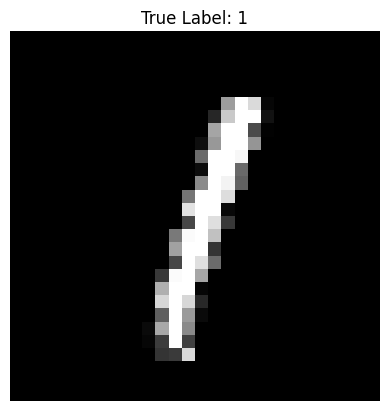

Predicted Probabilities: tensor([[0.0854, 0.2315, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854, 0.0854,
         0.0854]])
Uncertainty: tensor([[0.0019]])
Alpha Parameters: tensor([[1.1658e+00, 5.2202e+03, 1.5734e+00, 1.1877e+00, 1.2903e+00, 1.1423e+00,
         1.1165e+00, 1.1213e+00, 1.7402e+00, 1.0298e+00]])
True Label: 1


In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Assuming you have the original MNIST dataset loaded
transform_display = transforms.Compose([transforms.ToPILImage(), transforms.Resize((28, 28))])

# Display the original image
test_image, test_label = test_dataset[5]
plt.imshow(transform_display(test_image), cmap='gray')
plt.title(f'True Label: {test_label}')
plt.axis('off')
plt.show()
input_image = test_image.unsqueeze(0)
# Continue with the rest of the code for inference
lenet_dirichlet_mixup.eval()

with torch.no_grad():
    outputs, uncertainty, alpha = lenet_dirichlet_mixup(input_image)

probabilities = torch.nn.functional.softmax(outputs, dim=1)
print("Predicted Probabilities:", probabilities)
print("Uncertainty:", uncertainty)
print("Alpha Parameters:", alpha)
print("True Label:", test_label)

###**Evidential deep learning And Mixup CIFAR10**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

# Download CIFAR-10 dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
train_dataset = torchvision.datasets.CIFAR10(root='./data1', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data1', train=False, download=True, transform=transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

# LeNet model with Dirichlet distribution for Evidential Deep Learning and mixup
class LeNetDirichletCIFARMixup(nn.Module):
    def __init__(self):
        super(LeNetDirichletCIFARMixup, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(8*8*64, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool1(torch.relu(self.conv1(x)))
        x = self.pool2(torch.relu(self.conv2(x)))
        x = x.view(-1, 8*8*64)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)

        alpha = torch.abs(x) + 1

        u = 10 / torch.sum(alpha, dim=1, keepdim=True)

        prob = alpha / torch.sum(alpha, 1, keepdim=True)

        return prob, u, alpha

# Updated mixup function for Evidential Deep Learning
def mixup_data(x, y, alpha=0.1):
    lam = np.random.beta(alpha, alpha)
    batch_size = x.size()[0]
    index = torch.randperm(batch_size)
    mixed_x = lam * x + (1 - lam) * x[index, :]

    # Convert labels to one-hot encoding
    y_onehot = torch.zeros(y.size(0), 10).to(x.device)
    y_onehot.scatter_(1, y.view(-1, 1).long(), 1)
    mixed_y = lam * y_onehot + (1 - lam) * y_onehot[index, :]
    mixed_y = mixed_y.argmax(dim=1)
    return mixed_x, mixed_y


# Train LeNet model with Dirichlet distribution and mixup for Evidential Deep Learning
lenet_dirichlet_CIFAR_mixup = LeNetDirichletCIFARMixup()
criterion_dirichlet = nn.CrossEntropyLoss()
optimizer_dirichlet = optim.Adam(lenet_dirichlet_CIFAR_mixup.parameters(), lr=0.001)

for epoch in range(20):
    lenet_dirichlet_CIFAR_mixup.train()
    for inputs, labels in train_loader:
        inputs, labels = mixup_data(inputs, labels.unsqueeze(1))  # Assuming labels are one-dimensional

        optimizer_dirichlet.zero_grad()
        outputs, _, _ = lenet_dirichlet_CIFAR_mixup(inputs)

        # Cast labels back to Long data type
        labels = labels.squeeze().long()

        loss = criterion_dirichlet(outputs, labels)
        loss.backward()
        optimizer_dirichlet.step()

    lenet_dirichlet_CIFAR_mixup.eval()
    correct_train = 0
    total_train = 0
    with torch.no_grad():
        for inputs, labels in train_loader:
            outputs, _, _ = lenet_dirichlet_CIFAR_mixup(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs, _, _ = lenet_dirichlet_CIFAR_mixup(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    print('epoch %d - training accuracy: %2.4f \t testing accuracy: %2.4f' %
          (epoch+1, correct_train / total_train, correct_test / total_test))

Files already downloaded and verified
Files already downloaded and verified
epoch 1 - training accuracy: 0.5069 	 testing accuracy: 0.5043
epoch 2 - training accuracy: 0.5897 	 testing accuracy: 0.5683
epoch 3 - training accuracy: 0.6323 	 testing accuracy: 0.6005
epoch 4 - training accuracy: 0.6780 	 testing accuracy: 0.6246
epoch 5 - training accuracy: 0.7125 	 testing accuracy: 0.6485
epoch 6 - training accuracy: 0.7306 	 testing accuracy: 0.6515
epoch 7 - training accuracy: 0.7452 	 testing accuracy: 0.6604
epoch 8 - training accuracy: 0.7671 	 testing accuracy: 0.6730
epoch 9 - training accuracy: 0.7869 	 testing accuracy: 0.6823
epoch 10 - training accuracy: 0.7992 	 testing accuracy: 0.6848
epoch 11 - training accuracy: 0.7975 	 testing accuracy: 0.6717
epoch 12 - training accuracy: 0.8220 	 testing accuracy: 0.6890
epoch 13 - training accuracy: 0.8237 	 testing accuracy: 0.6861
epoch 14 - training accuracy: 0.8350 	 testing accuracy: 0.6922
epoch 15 - training accuracy: 0.8439 

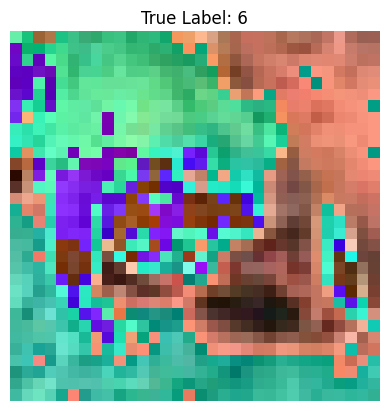

Predicted Probabilities: tensor([[0.0855, 0.0855, 0.0855, 0.0855, 0.0855, 0.0855, 0.2303, 0.0855, 0.0855,
         0.0855]])
Predicted Class: Frog
Uncertainty: 0.007052295375615358
Alpha Parameters: [1.1298736333847046, 1.167922019958496, 1.150836706161499, 1.6215661764144897, 1.2880825996398926, 1.050527572631836, 1406.2833251953125, 1.4581726789474487, 1.2837660312652588, 1.5439786911010742]
True Label: Frog


In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

# Assuming you have the original CIFAR-10 dataset loaded
transform_display = transforms.Compose([transforms.ToPILImage(), transforms.Resize((32, 32))])

# Display the original image
test_image, true_label = test_dataset[5]  # Access the 5th test image
plt.imshow(transform_display(test_image), cmap='gray')
plt.title(f'True Label: {true_label}')
plt.axis('off')
plt.show()

# Continue with the rest of the code for inference
lenet_dirichlet_CIFAR_mixup.eval()
class_labels = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

input_image = test_image.unsqueeze(0)

with torch.no_grad():
    outputs, uncertainty, alpha = lenet_dirichlet_CIFAR_mixup(input_image)

predicted_probabilities = torch.nn.functional.softmax(outputs, dim=1)
predicted_class = torch.argmax(predicted_probabilities, dim=1).item()

print("Predicted Probabilities:", predicted_probabilities)
print("Predicted Class:", class_labels[predicted_class])
print("Uncertainty:", uncertainty.item())
print("Alpha Parameters:", alpha.squeeze().tolist())
print("True Label:", class_labels[true_label])